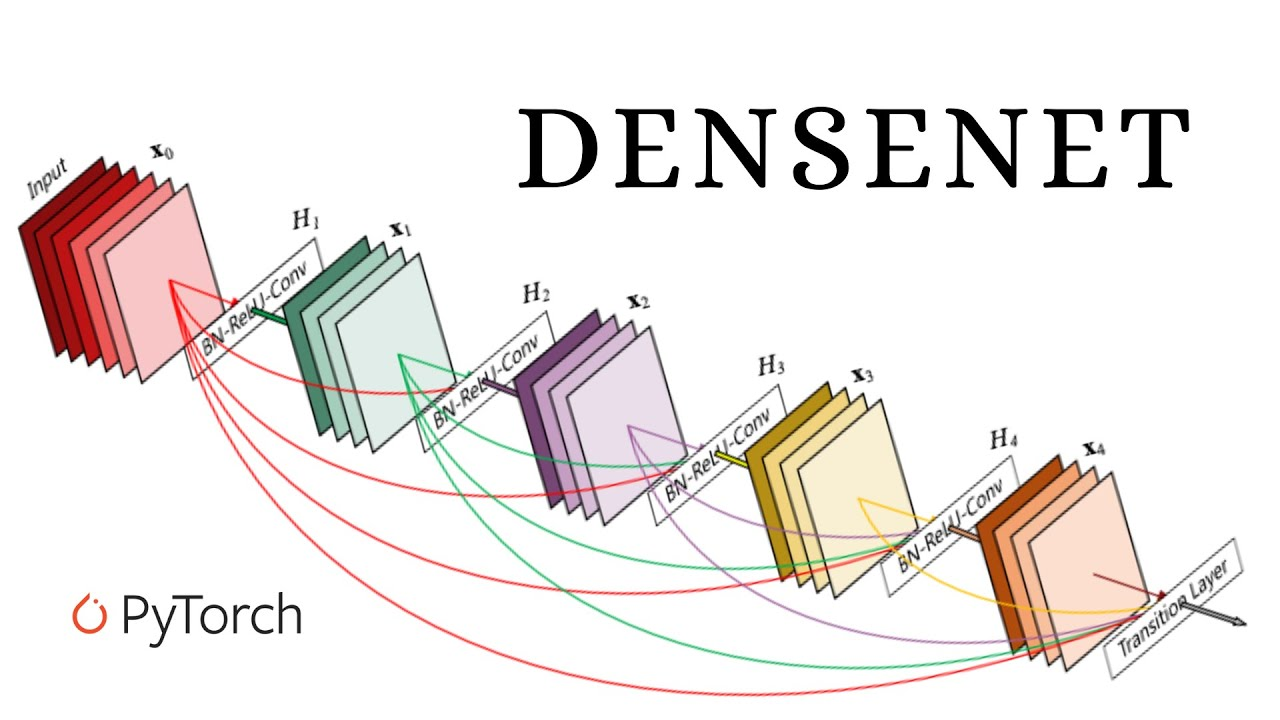

# Arquitectura de DenseNet

## Introducción

DenseNet (Densely Connected Convolutional Networks) es una red neuronal convolucional propuesta en 2017 por Gao Huang et al. en el paper "Densely Connected Convolutional Networks". Salió a partir de 2016, y se destaca por su eficiencia en parámetros y capacidad para mitigar el problema del vanishing gradient.

A diferencia de redes como ResNet (que usa sumas de atajos), DenseNet conecta cada capa con todas las siguientes dentro de bloques densos mediante **concatenación** de mapas de características. Esto promueve la reutilización de features, reduce el número de parámetros y mejora el flujo de información.

Ventajas clave:
- Menos parámetros que ResNet para rendimiento similar.
- Mejora la propagación de gradientes.
- Evaluada en datasets como CIFAR, SVHN e ImageNet, logrando resultados state-of-the-art con menos computación.


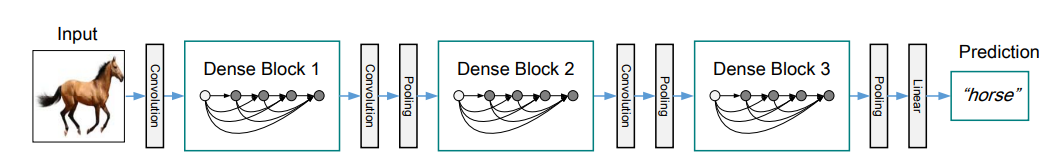

## Componentes Clave de DenseNet

1. **Bloques Densos (Dense Blocks)**:
   - Grupo de capas donde cada capa recibe como entrada la concatenación de los mapas de características de todas las capas anteriores en el bloque.
   - Si hay L capas en un bloque, la capa ℓ recibe k₀ + k × (ℓ - 1) entradas, donde k es la tasa de crecimiento (growth rate) y k₀ es el número inicial de canales.
   - Esto crea L(L+1)/2 conexiones directas, fomentando la reutilización de features.

2. **Función Compuesta (Composite Function)**:
   - Cada capa en un bloque denso aplica: Batch Normalization (BN) → ReLU → Convolución 3x3.
   - En variantes con bottleneck (DenseNet-B), se agrega una convolución 1x1 antes de la 3x3 para reducir dimensiones.

3. **Capas de Transición (Transition Layers)**:
   - Conectan bloques densos y reducen el tamaño espacial y el número de features.
   - Compuestas por: BN → Convolución 1x1 → Average Pooling 2x2 (stride 2).
   - Incluyen un factor de compresión θ (e.g., 0.5) para reducir features a ⌊θ × m⌋, donde m es el número de features entrantes.

4. **Tasa de Crecimiento (Growth Rate - k)**:
   - Número de nuevos mapas de características que añade cada capa (e.g., k=32 en ImageNet).
   - Un k pequeño es eficiente gracias a la concatenación.

5. **Bottleneck y Compresión**:
   - **Bottleneck**: Convolución 1x1 que produce 4k features antes de la 3x3, reduciendo cómputo.
   - **Compresión**: Reduce features en transiciones para mayor eficiencia (DenseNet-BC usa ambos).

Diferencias con ResNet: ResNet suma features (identity + residual), DenseNet las concatena, lo que permite más conexiones directas y menos parámetros.

## Estructura General de DenseNet

DenseNet típicamente tiene 4 bloques densos para ImageNet, con una capa inicial de convolución 7x7 y max pooling.

Ejemplo para DenseNet-121 (con bottleneck y compresión θ=0.5, k=32):
- **Capa Inicial**: Conv 7x7 (stride 2) → MaxPool 3x3 (stride 2).
- **Bloque Denso 1**: 6 capas [1x1 Conv → 3x3 Conv].
- **Transición 1**: 1x1 Conv → AvgPool 2x2.
- **Bloque Denso 2**: 12 capas [1x1 Conv → 3x3 Conv].
- **Transición 2**: 1x1 Conv → AvgPool 2x2.
- **Bloque Denso 3**: 24 capas [1x1 Conv → 3x3 Conv].
- **Transición 3**: 1x1 Conv → AvgPool 2x2.
- **Bloque Denso 4**: 16 capas [1x1 Conv → 3x3 Conv].
- **Clasificación**: Global Average Pooling → Fully Connected (para 1000 clases en ImageNet).

Parámetros totales: ~8M para DenseNet-121.

Otras variantes:
- DenseNet-169: Bloque 3 con 32 capas, Bloque 4 con 32 → ~14M params.
- DenseNet-201: Bloque 3 con 48 capas, Bloque 4 con 32 → ~20M params.
- DenseNet-264: Bloque 3 con 64 capas, Bloque 4 con 48 → ~33M params.

Ecuación clave para una capa ℓ: x_ℓ = H_ℓ([x_0, x_1, ..., x_{ℓ-1}]), donde [ ] es concatenación y H_ℓ es la función compuesta.


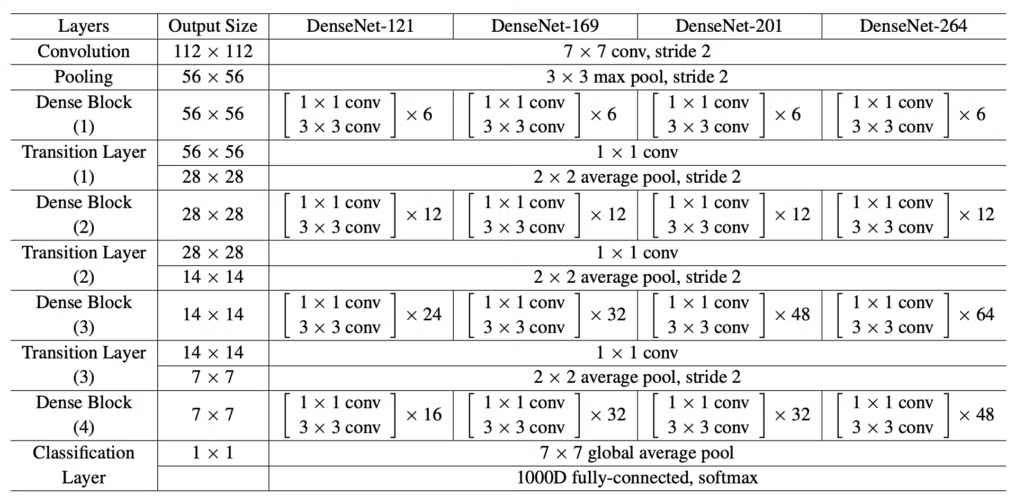

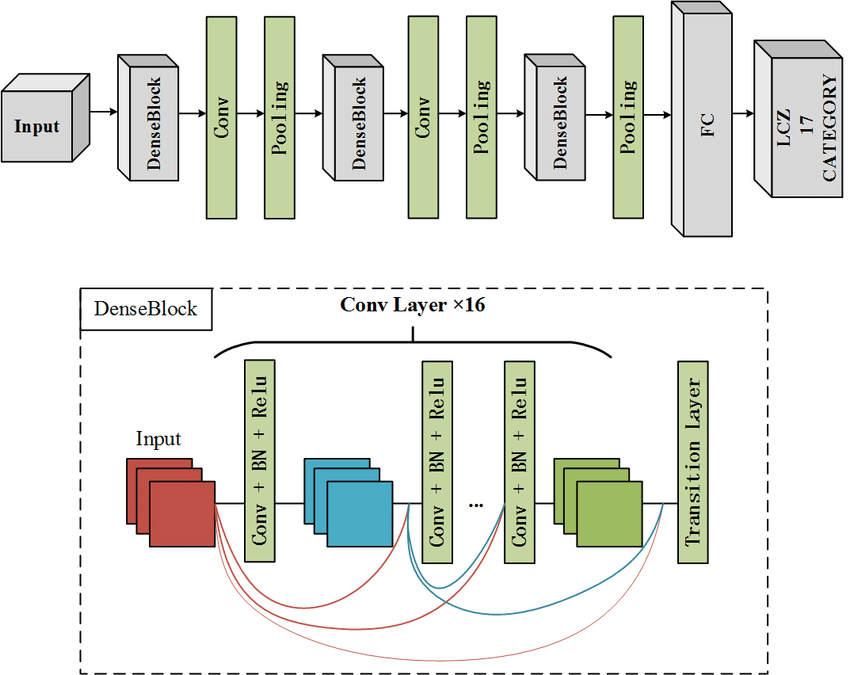

In [ ]:
# Importar bibliotecas necesarias
import torch
import torch.nn as nn
import torch.nn.functional as F

## Implementación en PyTorch

A continuación, implementamos DenseNet-121 desde cero. Definiremos:
- La capa densa (con bottleneck).
- El bloque denso.
- La capa de transición.
- La red completa.




In [ ]:
# Capa Densa (Dense Layer) con Bottleneck
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        # Bottleneck: 1x1 Conv para reducir a 4 * growth_rate
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        # Conv principal: 3x3
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        # Concatenar con la entrada
        return torch.cat([x, out], 1)

In [ ]:
# Bloque Denso (Dense Block)
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
# Capa de Transición (Transition Layer)
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        return self.pool(out)

In [ ]:
# Importar bibliotecas adicionales si no están ya
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time

# Configuración del dispositivo (GPU si disponible)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformaciones para los datos
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Aumento de datos
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalización para CIFAR-10
])

# Cargar dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Crear el modelo DenseNet-121 adaptado para CIFAR-10 (10 clases)
# Nota: Para CIFAR-10, ajustamos la capa inicial a Conv 3x3 en lugar de 7x7, y eliminamos MaxPool inicial para imágenes 32x32
class DenseNetCIFAR(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, num_classes=10, compression=0.5):
        super(DenseNetCIFAR, self).__init__()
        # Capa inicial adaptada para CIFAR-10 (imágenes 32x32)
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True)
            # No usamos MaxPool inicial para mantener tamaño
        )

        # Bloques Densos y Transiciones
        in_channels = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers, in_channels, growth_rate)
            self.features.add_module(f'denseblock{i+1}', block)
            in_channels = in_channels + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = TransitionLayer(in_channels, int(in_channels * compression))
                self.features.add_module(f'transition{i+1}', trans)
                in_channels = int(in_channels * compression)

        # Capa final
        self.features.add_module('norm5', nn.BatchNorm2d(in_channels))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.features.add_module('avgpool5', nn.AdaptiveAvgPool2d((1, 1)))

        self.classifier = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = torch.flatten(features, 1)
        out = self.classifier(out)
        return out

# Instanciar el modelo
model = DenseNetCIFAR(growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, num_classes=10)
model.to(device)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)  # Común para DenseNet en CIFAR

# Scheduler para ajustar learning rate (opcional, pero recomendado)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1)  # Ajusta según épocas totales

# Función de entrenamiento
def train(epoch):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # Imprimir cada 100 batches
            print(f'[Época {epoch+1}, Batch {i+1}] Pérdida: {running_loss / 100:.3f}')
            running_loss = 0.0

# Función de evaluación
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Precisión en test: {100 * correct / total:.2f}%')

# Entrenamiento por 5 épocas (aumentar a 300 para resultados reales, pero toma tiempo en Colab)
num_epochs = 50
start_time = time.time()
for epoch in range(num_epochs):
    train(epoch)
    scheduler.step()
    test()
print(f'Tiempo total de entrenamiento: {time.time() - start_time:.2f} segundos')

Usando dispositivo: cuda:0


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


[Época 1, Batch 100] Pérdida: 2.077
[Época 1, Batch 200] Pérdida: 1.752
[Época 1, Batch 300] Pérdida: 1.584
Precisión en test: 45.70%
[Época 2, Batch 100] Pérdida: 1.377
[Época 2, Batch 200] Pérdida: 1.287
[Época 2, Batch 300] Pérdida: 1.201
Precisión en test: 58.69%
[Época 3, Batch 100] Pérdida: 1.033
[Época 3, Batch 200] Pérdida: 1.012
[Época 3, Batch 300] Pérdida: 0.953
Precisión en test: 62.25%
[Época 4, Batch 100] Pérdida: 0.867
[Época 4, Batch 200] Pérdida: 0.858
[Época 4, Batch 300] Pérdida: 0.796
Precisión en test: 67.61%
[Época 5, Batch 100] Pérdida: 0.733
[Época 5, Batch 200] Pérdida: 0.739
[Época 5, Batch 300] Pérdida: 0.721
Precisión en test: 72.94%
[Época 6, Batch 100] Pérdida: 0.653
[Época 6, Batch 200] Pérdida: 0.648
[Época 6, Batch 300] Pérdida: 0.628
Precisión en test: 77.26%
[Época 7, Batch 100] Pérdida: 0.584
[Época 7, Batch 200] Pérdida: 0.560
[Época 7, Batch 300] Pérdida: 0.570
Precisión en test: 77.48%
[Época 8, Batch 100] Pérdida: 0.502
[Época 8, Batch 200] Pérdi

**Flujo de la Imagen a Través de DenseNet-121**

**1. Capa Inicial (Initial Convolution Layer)**

Qué hace: La imagen entra a una capa convolucional inicial diseñada para CIFAR-10 (imágenes pequeñas). En lugar de la Conv 7x7 con stride 2 de DenseNet para ImageNet, usamos una Conv 3x3 con stride 1 y padding 1, seguida de Batch Normalization (BN) y ReLU. No usamos MaxPool inicial para preservar el tamaño espacial de 32x32.
Cambio en dimensiones:

Entrada: 32x32x3 (3 canales para RGB).
Conv 3x3: Kernel 3x3, stride 1, padding 1, produce 64 canales (num_init_features=64). El padding asegura que el tamaño espacial no cambie: (32 - 3 + 2×1)/1 + 1 = 32.
Salida: 32x32x64 (alto × ancho × canales).


Conceptos clave:

La Conv 3x3 extrae patrones básicos (bordes, texturas).
Padding=1 mantiene el tamaño espacial (crucial para imágenes pequeñas como 32x32).
BN normaliza activaciones para estabilizar el entrenamiento; ReLU añade no-linealidad.


En el código:
pythonself.features = nn.Sequential(
    nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(num_init_features),
    nn.ReLU(inplace=True)
)


**2. Bloque Denso 1 (Dense Block 1 - 6 capas)**

Qué hace: La imagen pasa al primer bloque denso, que tiene 6 capas densas. Cada capa densa aplica BN → ReLU → Conv 1x1 → BN → ReLU → Conv 3x3 (estructura bottleneck). Cada capa produce k=32 nuevos canales, que se concatenan a la entrada.
Cambio en dimensiones:

Entrada: 32x32x64 (de la capa inicial).
Por capa:

La Conv 1x1 (bottleneck) reduce los canales entrantes a 4k=128 (independiente de los canales de entrada).
La Conv 3x3 produce k=32 canales.
Estos 32 canales se concatenan a la entrada.


Cálculo de canales:

Capa 1: Entrada 64 canales → Salida 64 + 32 = 96 canales.
Capa 2: Entrada 96 canales → Salida 96 + 32 = 128 canales.
Capa 3: Entrada 128 canales → Salida 128 + 32 = 160 canales.
Capa 4: Entrada 160 canales → Salida 160 + 32 = 192 canales.
Capa 5: Entrada 192 canales → Salida 192 + 32 = 224 canales.
Capa 6: Entrada 224 canales → Salida 224 + 32 = 256 canales.


Tamaño espacial: Las convoluciones 3x3 usan padding=1, así que el tamaño se mantiene en 32x32.
Salida del bloque: 32x32x256.


Conceptos clave:

Conexiones densas: Cada capa recibe todos los feature maps anteriores (e.g., la capa 6 recibe [x₀, x₁, x₂, x₃, x₄, x₅]). Esto fomenta reutilización de características.
Bottleneck: La Conv 1x1 reduce canales a 4k=128 antes de la 3x3, ahorrando cómputo (sin esto, la 3x3 operaría sobre cientos de canales).
Tasa de crecimiento (k=32): Cada capa añade 32 canales nuevos, controlando el crecimiento.


En el código:
pythonblock = DenseBlock(num_layers=6, in_channels=64, growth_rate=32)


**3. Capa de Transición 1 (Transition Layer 1)**

Qué hace: Reduce el número de canales y el tamaño espacial entre bloques densos. Aplica BN → ReLU → Conv 1x1 → AvgPool 2x2 (stride 2).
Cambio en dimensiones:

Entrada: 32x32x256 (del bloque denso 1).
Conv 1x1: Reduce canales con compresión θ=0.5: 256 × 0.5 = 128 canales.
AvgPool 2x2 (stride 2): Reduce el tamaño espacial a la mitad: 32/2 = 16x16.
Salida: 16x16x128.


Conceptos clave:

Compresión (θ=0.5): Reduce canales para mantener la red eficiente.
Downsampling: AvgPool 2x2 reduce resolución espacial, enfocándose en patrones más abstractos.


En el código:
pythontrans = TransitionLayer(in_channels=256, out_channels=int(256 * 0.5))


**4. Bloque Denso 2 (Dense Block 2 - 12 capas)**

Qué hace: Similar al bloque 1, pero con 12 capas densas. Cada capa añade k=32 canales.
Cambio en dimensiones:

Entrada: 16x16x128.
Por capa: Cada capa produce 32 canales nuevos.
Cálculo de canales:

Capa 1: 128 + 32 = 160 canales.
Capa 2: 160 + 32 = 192 canales.
...
Capa 12: 128 + 12 × 32 = 512 canales.


Tamaño espacial: Se mantiene en 16x16 (Conv 3x3 con padding=1).
Salida: 16x16x512.


Conceptos clave:

Más capas (12 vs. 6) significan más capacidad para aprender patrones complejos.
Las conexiones densas aseguran que todas las capas anteriores contribuyen a la salida, mejorando el flujo de gradientes.



**5. Capa de Transición 2 (Transition Layer 2)**

Qué hace: Igual que la transición 1.
Cambio en dimensiones:

Entrada: 16x16x512.
Conv 1x1: 512 × 0.5 = 256 canales.
AvgPool 2x2: 16/2 = 8x8.
Salida: 8x8x256.


Conceptos clave: Similar a la transición 1, reduce canales y resolución para el siguiente bloque.

**6. Bloque Denso 3 (Dense Block 3 - 24 capas)**

Qué hace: Tiene 24 capas densas, la mayor cantidad, para capturar patrones muy abstractos.
Cambio en dimensiones:

Entrada: 8x8x256.
Cálculo de canales:

Capa 1: 256 + 32 = 288 canales.
...
Capa 24: 256 + 24 × 32 = 1024 canales.


Tamaño espacial: 8x8.
Salida: 8x8x1024.


Conceptos clave:

El número de canales crece significativamente, pero el bottleneck (Conv 1x1) evita que el cómputo sea inviable.
Las conexiones densas permiten que features de baja resolución (8x8) se combinen con las de capas anteriores.



**7. Capa de Transición 3 (Transition Layer 3)**

Qué hace: Reduce canales y tamaño.
Cambio en dimensiones:

Entrada: 8x8x1024.
Conv 1x1: 1024 × 0.5 = 512 canales.
AvgPool 2x2: 8/2 = 4x4.
Salida: 4x4x512.



**8. Bloque Denso 4 (Dense Block 4 - 16 capas)**

Qué hace: Último bloque con 16 capas densas.
Cambio en dimensiones:

Entrada: 4x4x512.
Cálculo de canales:

Capa 1: 512 + 32 = 544 canales.
...
Capa 16: 512 + 16 × 32 = 1024 canales.


Tamaño espacial: 4x4.
Salida: 4x4x1024.


Conceptos clave: Prepara features finales para la clasificación, combinando patrones de alto nivel.

**9. Capa de Clasificación (Classification Layer)**

Qué hace: Aplica BN → ReLU → Global Average Pooling (GAP) → Fully Connected (FC).
Cambio en dimensiones:

Entrada: 4x4x1024.
GAP: Promedia cada canal, reduciendo 4x4 a 1x1 por canal: 1x1x1024 (vector de 1024).
FC: Transforma 1024 canales a 10 clases (para CIFAR-10).
Salida: Vector de 10 elementos (logits para las clases).


Conceptos clave:

GAP: Reduce parámetros (vs. flattening + FC grande) y actúa como regularizador.
FC: Produce scores para cada clase, usados con softmax en la loss (CrossEntropy).


En el código:
pythonself.features.add_module('norm5', nn.BatchNorm2d(in_channels))
self.features.add_module('relu5', nn.ReLU(inplace=True))
self.features.add_module('avgpool5', nn.AdaptiveAvgPool2d((1, 1)))
self.classifier = nn.Linear(in_channels, num_classes)



Resumen del Flujo

Entrada: 32x32x3 (imagen RGB).
Capa Inicial: 32x32x64.
Bloque Denso 1 (6 capas): 32x32x256.
Transición 1: 16x16x128.
Bloque Denso 2 (12 capas): 16x16x512.
Transición 2: 8x8x256.
Bloque Denso 3 (24 capas): 8x8x1024.
Transición 3: 4x4x512.
Bloque Denso 4 (16 capas): 4x4x1024.
Clasificación: Vector de 10 (clases).